## Multiple Drivers at once

In [1]:
import os
import pandas as pd
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # convert to meters

    return distance

def process_log_line(line):
    if "Feedback Code Starting" in line:
        return None

    sections = line.split(' :- ')

    if len(sections) != 2:
        return None

    log_timestamp = sections[0].strip().split(',')[0]
    log_details = sections[1].strip()

    details_parts = log_details.split(':')
    log_seq = details_parts[0]
    data_dict = {'Log_seq': int(log_seq)}

    mabx_values = [item.strip() for item in details_parts[1:]]
    data_dict['Timestamp'] = log_timestamp
    seq, veh_speed, tire_angle = map(float, mabx_values[0].split('||')[0].split(','))

    data_dict['MABX_seq'] = int(seq)
    data_dict['Veh_MABX_Speed'] = veh_speed
    data_dict['Tire_Angle'] = tire_angle

    # unix_time = mabx_values[0].split('||')[1].strip().split(',')[0]

    gnss_values = mabx_values[0].split('||')[1].strip().split(',')
    if len(gnss_values) == 10:
        unixtime, lat, lng, lat_std, lng_std, gnss_speed, acc, roll, pitch, heading = map(float, gnss_values)
        data_dict['Unixtime'] = int(unixtime)
        data_dict['Lat'] = lat
        data_dict['Lng'] = lng
        data_dict['Lat_std'] = lat_std
        data_dict['Lng_std'] = lng_std
        data_dict['Veh_GNSS_Speed'] = gnss_speed
        data_dict['Z_Acc'] = acc
        data_dict['Roll'] = roll
        data_dict['Pitch'] = pitch
        data_dict['Heading'] = heading
    else:
        # print(f"Skipping line due to unexpected number of values: {len(gnss_values)} in line: {line}")
        return None

    return data_dict

def read_and_process_log_file(file_path, dataframe):
    with open(file_path, 'r') as file:
        file_content = file.read()

    file_lines = file_content.split('\n')

    data_list = []

    for line in file_lines:
        data_dict = process_log_line(line)
        if data_dict is not None:
            data_list.append(data_dict)

    if data_list:
        dataframe = pd.concat([dataframe, pd.DataFrame(data_list)], ignore_index=True)

    return dataframe

def find_nearest_point(reference_lat, reference_lon, df):
    """
    Find the nearest point in the DataFrame `df` to the given reference latitude and longitude.
    """
    # Calculate the distance from each point in the DataFrame to the reference point
    distances = df.apply(lambda row: haversine_vectorized(reference_lat, reference_lon, row['Lat'], row['Lng']), axis=1)

    # Find the index of the point with the smallest distance
    nearest_idx = distances.idxmin()

    # Retrieve the information about the nearest point
    nearest_point_info = df.loc[nearest_idx]

    return nearest_point_info

data = {}

# extract all the folders in the directory
directory_path = '/home/ninerishav/TiHANLab-Codes/Solio-Suzuki/navigation/SingletonCodes/autonomous-mode/Shared-To-Suzuki/SpeedBreaker'

items = os.listdir(directory_path)
items.sort()
folder_paths = [os.path.join(directory_path, item) for item in items if os.path.isdir(os.path.join(directory_path, item))]


# Process log files in each folder path
for folder_path in folder_paths:
    folder_name = os.path.basename(os.path.normpath(folder_path))  # Get the last word of the path

    # Initialize DataFrames for each type
    auto10_df = pd.DataFrame()
    auto20_df = pd.DataFrame()
    auto30_df = pd.DataFrame()

    for filename in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".log") and os.path.isfile(file_path):
            if 'auto10' in filename:
                auto10_df = read_and_process_log_file(file_path, auto10_df)
            elif 'auto20' in filename:
                auto20_df = read_and_process_log_file(file_path, auto20_df)
            elif 'auto30' in filename:
                auto30_df = read_and_process_log_file(file_path, auto30_df)

    # Find nearest point for each DataFrame
    given_start_lat, given_start_lon = 17.60173042438856, 78.12660632898064
    speedbump_lat,speedbump_long     = 17.602129204103562, 78.12660004713902
    if not auto10_df.empty:
        #auto10_df['dist_start'] = auto10_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], given_start_lat, given_start_lon), axis=1)
        nearest_point_auto10 = find_nearest_point(given_start_lat, given_start_lon, auto10_df)
        auto10_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto10['Lat'], nearest_point_auto10['Lng'], auto10_df['Lat'], auto10_df['Lng'])
        auto10_df['dist_from_speedbreaker'] = auto10_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], speedbump_lat, speedbump_long ), axis=1)

    if not auto20_df.empty:
        #auto20_df['dist_start'] = auto20_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], given_start_lat, given_start_lon), axis=1)
        nearest_point_auto20 = find_nearest_point(given_start_lat, given_start_lon, auto20_df)
        auto20_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto20['Lat'], nearest_point_auto20['Lng'], auto20_df['Lat'], auto20_df['Lng'])
        auto20_df['dist_from_speedbreaker'] = auto20_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], speedbump_lat, speedbump_long ), axis=1)

    if not auto30_df.empty:
        #auto30_df['dist_start'] = auto30_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], given_start_lat, given_start_lon), axis=1)
        nearest_point_auto30 = find_nearest_point(given_start_lat, given_start_lon, auto30_df)
        auto30_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto30['Lat'], nearest_point_auto30['Lng'], auto30_df['Lat'], auto30_df['Lng'])
        auto30_df['dist_from_speedbreaker'] = auto30_df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], speedbump_lat, speedbump_long ), axis=1)

    # Add the DataFrames to the main data dictionary using the folder name as the key
    data[folder_name] = {
        'auto10': auto10_df.copy(),
        'auto20': auto20_df.copy(),
        'auto30': auto30_df.copy(),
    }

    # Confirm that the dataframes are not empty
    for key, value in data[folder_name].items():
        if value.empty:
            print(f"Empty DataFrame for {folder_name} - {key}")


In [2]:
speedbump_lat,speedbump_long = 17.602129204103562, 78.12660004713902
bump_location=haversine_vectorized(given_start_lat, given_start_lon,speedbump_lat,speedbump_long)
print(bump_location)

44.34727944979808


### Some Information about the dataframe

In [3]:
print(f"Number of drivers: {len(data)}")

Number of drivers: 5


In [4]:
data['Aravind']['auto20'].head(5)

,Log_seq,Timestamp,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,nearest_dist_from_start,dist_from_speedbreaker
0,2,2024-01-22 16:48:58,86,20.0,-0.1,1705922338,17.601624,78.12661,0.01,0.01,24.82,9.69,0.77,-0.25,359.42,11.712231,56.206274
1,3,2024-01-22 16:48:58,89,20.0,-0.1,1705922338,17.601630,78.12661,0.01,0.01,24.87,9.60,0.75,-0.25,359.41,11.018130,55.512177
2,4,2024-01-22 16:48:58,92,20.0,-0.1,1705922338,17.601630,78.12661,0.01,0.01,24.87,9.76,0.73,-0.28,359.40,11.018130,55.512177
3,5,2024-01-22 16:48:58,95,20.0,-0.1,1705922338,17.601630,78.12661,0.01,0.01,24.87,9.85,0.73,-0.29,359.40,11.018130,55.512177
4,6,2024-01-22 16:48:58,98,20.0,-0.1,1705922338,17.601636,78.12661,0.01,0.01,24.78,9.97,0.72,-0.32,359.39,10.326566,54.820617


In [5]:
data['Aravind']['auto20'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Log_seq                  606 non-null    int64  
 1   Timestamp                606 non-null    object 
 2   MABX_seq                 606 non-null    int64  
 3   Veh_MABX_Speed           606 non-null    float64
 4   Tire_Angle               606 non-null    float64
 5   Unixtime                 606 non-null    int64  
 6   Lat                      606 non-null    float64
 7   Lng                      606 non-null    float64
 8   Lat_std                  606 non-null    float64
 9   Lng_std                  606 non-null    float64
 10  Veh_GNSS_Speed           606 non-null    float64
 11  Z_Acc                    606 non-null    float64
 12  Roll                     606 non-null    float64
 13  Pitch                    606 non-null    float64
 14  Heading                  6

In [6]:
data['Aravind']['auto10'].describe()

,Log_seq,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,nearest_dist_from_start,dist_from_speedbreaker
count,986.000000,986.000000,986.000000,986.000000,9.860000e+02,986.000000,986.000000,9.860000e+02,9.860000e+02,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,494.633874,127.882353,11.323124,-0.177383,1.705922e+09,17.602013,78.126605,1.000000e-02,1.000000e-02,11.628063,9.812373,0.685497,-0.221957,275.038824,32.613646,22.505450
std,284.979053,74.875344,5.331920,0.309520,8.576290e+00,0.000221,0.000003,1.683536e-16,1.683536e-16,5.439834,0.595937,0.389249,0.307984,151.965484,22.773642,16.270097
min,2.000000,0.000000,4.400000,-0.900000,1.705922e+09,17.601637,78.126599,1.000000e-02,1.000000e-02,3.850000,3.640000,-0.040000,-1.350000,0.000000,0.000000,0.290216
25%,248.250000,62.000000,10.000000,-0.400000,1.705922e+09,17.601827,78.126603,1.000000e-02,1.000000e-02,9.730000,9.680000,0.360000,-0.330000,358.340000,10.643927,7.225531
50%,494.500000,129.000000,10.000000,-0.100000,1.705922e+09,17.602023,78.126604,1.000000e-02,1.000000e-02,10.200000,9.810000,0.660000,-0.200000,358.900000,32.396022,20.901710
75%,740.750000,193.000000,10.000000,0.000000,1.705922e+09,17.602148,78.126608,1.000000e-02,1.000000e-02,10.950000,9.940000,0.940000,-0.050000,359.270000,46.282603,36.218414
max,988.000000,255.000000,24.400000,0.700000,1.705922e+09,17.602507,78.126610,1.000000e-02,1.000000e-02,24.940000,14.500000,1.760000,1.200000,359.990000,86.240191,54.725932


### Boxplot

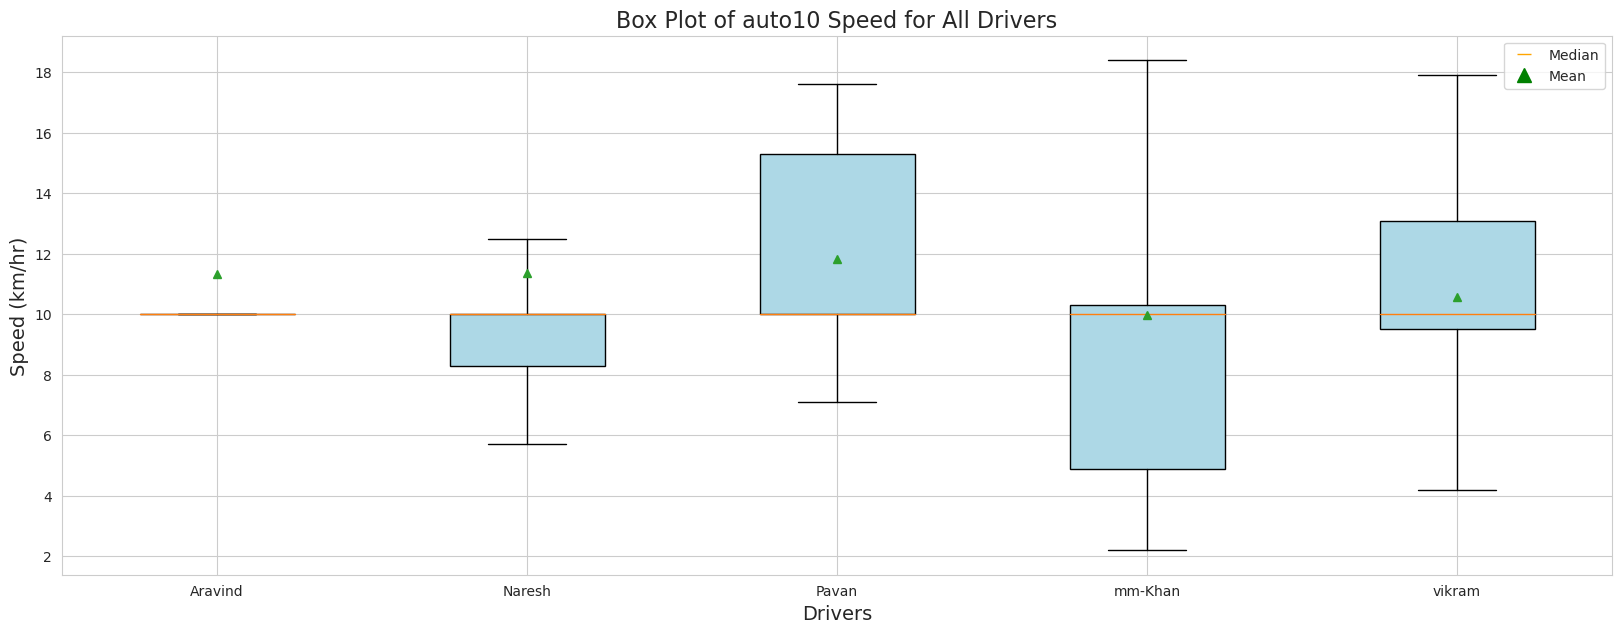

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto10' in folder_data:
        boxplot_data1.append(folder_data['auto10']['Veh_MABX_Speed'])

plt.figure(figsize=(20, 7))
# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False, )

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto10 Speed for All Drivers', fontsize=16)
plt.show()


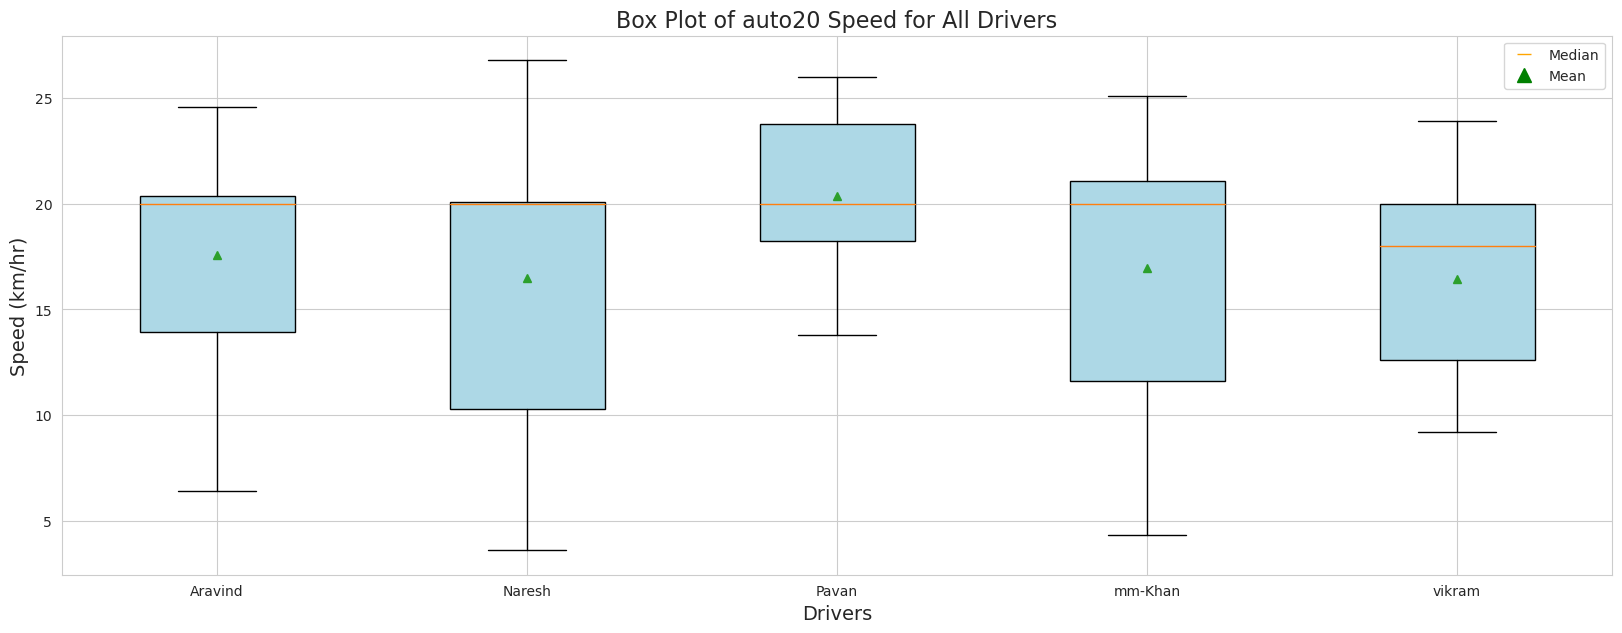

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto20' in folder_data:
        boxplot_data1.append(folder_data['auto20']['Veh_MABX_Speed'])

plt.figure(figsize=(20, 7))
# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False)

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto20 Speed for All Drivers', fontsize=16)
plt.show()

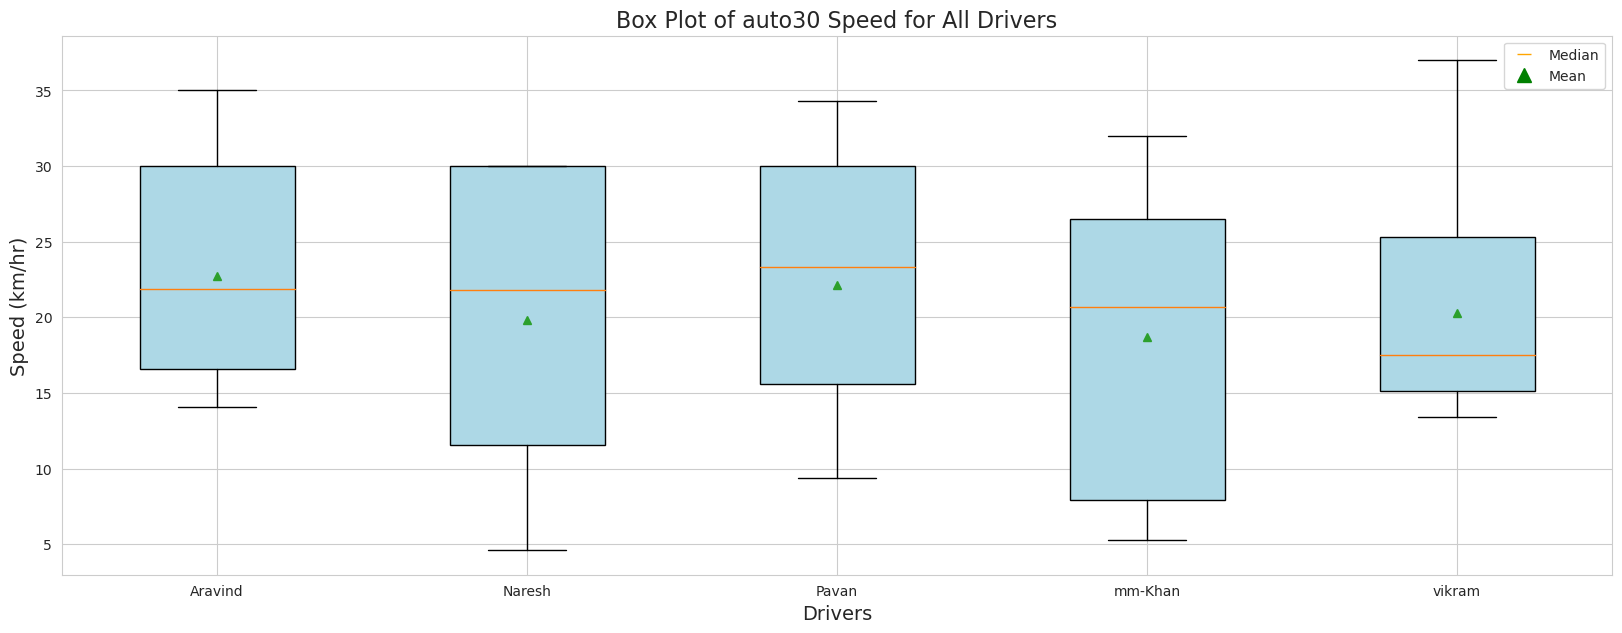

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto30' in folder_data:
        boxplot_data1.append(folder_data['auto30']['Veh_MABX_Speed'])

plt.figure(figsize=(20, 7))
# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False)

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto30 Speed for All Drivers', fontsize=16)
plt.show()

### Checking Z_Acceleration

In [10]:
max_min_z_acc = {}

for user_name, user_data in data.items():
    max_min_z_acc[user_name] = {}
    for df_name, df in user_data.items():
        max_z_acc_idx = df['Z_Acc'].idxmax()
        min_z_acc_idx = df['Z_Acc'].idxmin()
        
        max_z_acc = df.loc[max_z_acc_idx, 'Z_Acc']
        min_z_acc = df.loc[min_z_acc_idx, 'Z_Acc']
        
        max_z_acc_dist = df.loc[max_z_acc_idx, 'nearest_dist_from_start']
        min_z_acc_dist = df.loc[min_z_acc_idx, 'nearest_dist_from_start']
        
        max_min_z_acc[user_name][df_name] = {'max': max_z_acc, 'max_dist': max_z_acc_dist, 'min': min_z_acc, 'min_dist': min_z_acc_dist, 'avg_max-min-dist': (max_z_acc_dist + min_z_acc_dist) / 2}

max_min_z_acc

{'Aravind': {'auto10': {'max': 14.5,
   'max_dist': 45.125613902522566,
   'min': 3.64,
   'min_dist': 44.77428775199503,
   'avg_max-min-dist': 44.9499508272588},
  'auto20': {'max': 16.19,
   'max_dist': 44.58662326785287,
   'min': 0.81,
   'min_dist': 45.033887557747846,
   'avg_max-min-dist': 44.81025541280036},
  'auto30': {'max': 19.38,
   'max_dist': 44.40812338298983,
   'min': -0.56,
   'min_dist': 44.86099613034549,
   'avg_max-min-dist': 44.634559756667656}},
 'Naresh': {'auto10': {'max': 15.28,
   'max_dist': 45.34450330119491,
   'min': 2.47,
   'min_dist': 44.905462669656565,
   'avg_max-min-dist': 45.12498298542574},
  'auto20': {'max': 15.63,
   'max_dist': 45.16748659966633,
   'min': 1.07,
   'min_dist': 44.5946928082135,
   'avg_max-min-dist': 44.88108970393992},
  'auto30': {'max': 15.29,
   'max_dist': 44.890333673503164,
   'min': 3.43,
   'min_dist': 44.65219434284554,
   'avg_max-min-dist': 44.771264008174356}},
 'Pavan': {'auto10': {'max': 18.02,
   'max_dist'

In [11]:
ending_point = {}

for user_name, user_data in data.items():
    ending_point[user_name] = {}
    for df_name, df in user_data.items():
        max_z_acc_index = df['Z_Acc'].idxmax()
        ending_point[user_name][df_name] = max_z_acc_index

starting_point = {}

for user_name, user_data in data.items():
    starting_point[user_name] = {}
    for df_name, df in user_data.items():
        
        if 'auto10' in df_name:
            speed = 10.0
        elif 'auto20' in df_name:
            speed = 20.0
        elif 'auto30' in df_name:
            speed = 30.0

        indices_for_speed = df[df['Veh_MABX_Speed'] == speed].index
        indices_for_speed = indices_for_speed[indices_for_speed < ending_point[user_name][df_name]]
        
        if not indices_for_speed.empty:
            max_speed_idx = indices_for_speed[-2]               # Post analysis, it was found that the last index was not the max speed index, so using the second last index
            starting_point[user_name][df_name] = max_speed_idx
        else:
            starting_point[user_name][df_name] = None

print(starting_point)
print(ending_point)

{'Aravind': {'auto10': 543, 'auto20': 215, 'auto30': 119}, 'Naresh': {'auto10': 464, 'auto20': 156, 'auto30': 149}, 'Pavan': {'auto10': 480, 'auto20': 163, 'auto30': 114}, 'mm-Khan': {'auto10': 373, 'auto20': 183, 'auto30': 100}, 'vikram': {'auto10': 457, 'auto20': 148, 'auto30': 56}}
{'Aravind': {'auto10': 712, 'auto20': 322, 'auto30': 207}, 'Naresh': {'auto10': 687, 'auto20': 367, 'auto30': 304}, 'Pavan': {'auto10': 701, 'auto20': 258, 'auto30': 264}, 'mm-Khan': {'auto10': 607, 'auto20': 315, 'auto30': 282}, 'vikram': {'auto10': 614, 'auto20': 259, 'auto30': 172}}


In [12]:
# print(data['Aravind']['auto20'].iloc[starting_point['Aravind']['auto20']])
print(data['Pavan']['auto20'].iloc[ending_point['Pavan']['auto20']])

Log_seq                                    265
Timestamp                  2024-02-16 12:31:19
MABX_seq                                   135
Veh_MABX_Speed                            14.3
Tire_Angle                                 0.0
Unixtime                            1708066879
Lat                                   17.60213
Lng                                  78.126603
Lat_std                                   0.01
Lng_std                                   0.01
Veh_GNSS_Speed                           14.86
Z_Acc                                    25.87
Roll                                       1.4
Pitch                                     0.33
Heading                                 359.73
nearest_dist_from_start              44.188844
dist_from_speedbreaker                0.319192
Name: 258, dtype: object


##### For all users Reaction distance 

In [13]:
reaction_distance = {}

for user_name, user_data in data.items():
    reaction_distance[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['nearest_dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['nearest_dist_from_start']
        else:
            reaction_distance[user_name][df_name] = None
    
reaction_distance


{'Aravind': {'auto10': 8.649848650934473,
  'auto20': 13.4463584688168,
  'auto30': 19.4850230961339},
 'Naresh': {'auto10': 9.584673392567254,
  'auto20': 18.597673998840236,
  'auto30': 18.5919116192388},
 'Pavan': {'auto10': 20.330304378598385,
  'auto20': 15.311361910417794,
  'auto30': 27.086756326452374},
 'mm-Khan': {'auto10': 8.650211748743281,
  'auto20': 12.561301682021863,
  'auto30': 21.18411568073474},
 'vikram': {'auto10': 8.500702067391387,
  'auto20': 17.116884513120745,
  'auto30': 26.950864796079554}}

In [14]:
reaction_distance_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    reaction_distance_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['nearest_dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['nearest_dist_from_start']
        else:
            reaction_distance_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_distance_df = pd.DataFrame(reaction_distance_mean)

# Calculate the mean for each DataFrame
reaction_distance = reaction_distance_df.mean(axis=0).to_dict()
reaction_distance_median = reaction_distance_df.median(axis=0).to_dict()

print(reaction_distance)
print(reaction_distance_median)


{'auto10': 11.143148047646957, 'auto20': 15.406716114643487, 'auto30': 22.659734303727877}
{'auto10': 8.650211748743281, 'auto20': 15.311361910417794, 'auto30': 21.18411568073474}


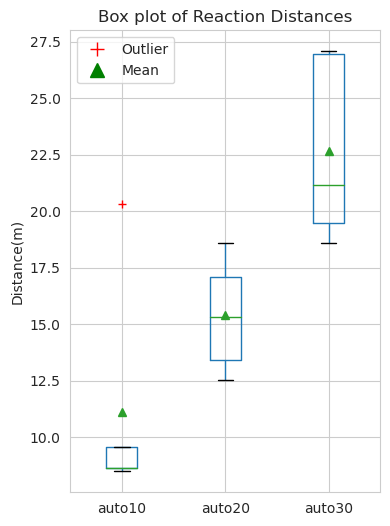

In [15]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_distance_df.boxplot(sym='r+', showmeans=True)
plt.title('Box plot of Reaction Distances')
plt.ylabel('Distance(m)')
plt.xticks()  # Rotate x-axis labels for better visibility if needed

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.show()

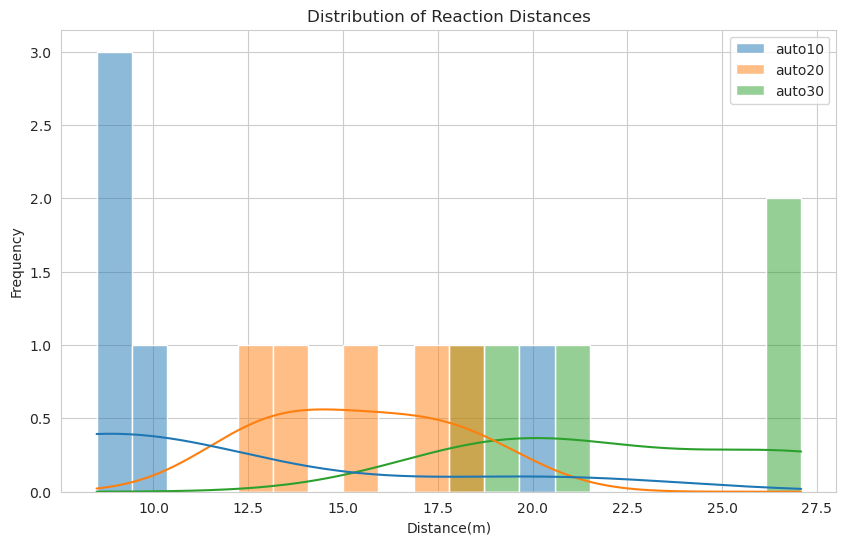

In [16]:
# draw distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(reaction_distance_df, kde=True, bins=20)
plt.title('Distribution of Reaction Distances')
plt.xlabel('Distance(m)')
plt.ylabel('Frequency')
plt.show()


#### For all users Reaction time

In [17]:
reaction_time = {}

for user_name, user_data in data.items():
    reaction_time[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time[user_name][df_name] = None
    
reaction_time

{'Aravind': {'auto10': 5, 'auto20': 4, 'auto30': 3},
 'Naresh': {'auto10': 7, 'auto20': 6, 'auto30': 5},
 'Pavan': {'auto10': 7, 'auto20': 3, 'auto30': 4},
 'mm-Khan': {'auto10': 8, 'auto20': 4, 'auto30': 5},
 'vikram': {'auto10': 5, 'auto20': 4, 'auto30': 3}}

In [18]:
reaction_time_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    reaction_time_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_time_df = pd.DataFrame(reaction_time_mean)

#filter extreme values
reaction_time_df = reaction_time_df[reaction_time_df < 20]

# Calculate the mean for each DataFrame
mean_time = reaction_time_df.mean(axis=0).to_dict()
median_time = reaction_time_df.median(axis=0).to_dict()

print(mean_time)
print(median_time)

{'auto10': 6.4, 'auto20': 4.2, 'auto30': 4.0}
{'auto10': 7.0, 'auto20': 4.0, 'auto30': 4.0}


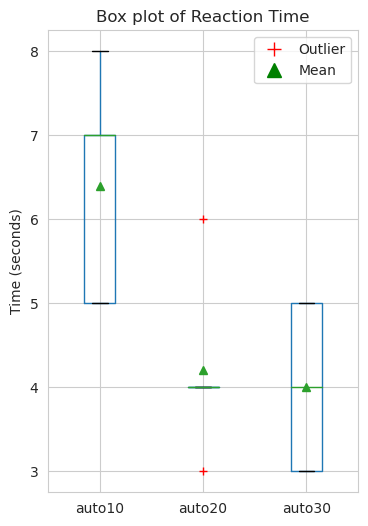

In [19]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_time_df.boxplot(sym='r+', showmeans=True, )
plt.title('Box plot of Reaction Time')
plt.ylabel('Time (seconds)')

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.xticks()  # Rotate x-axis labels for better visibility if needed
plt.show()

#### Speed at SpeedBreaker

In [20]:
#find average speed at endpoints
speeds = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    speeds[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            speeds[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Veh_MABX_Speed']
        else:
            speeds[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
speed_df = pd.DataFrame(speeds)
speeds

{'auto10': {'Aravind': 4.4,
  'Naresh': 5.5,
  'Pavan': 16.1,
  'mm-Khan': 3.9,
  'vikram': 4.2},
 'auto20': {'Aravind': 7.1,
  'Naresh': 7.6,
  'Pavan': 14.3,
  'mm-Khan': 4.4,
  'vikram': 10.4},
 'auto30': {'Aravind': 15.4,
  'Naresh': 4.8,
  'Pavan': 9.5,
  'mm-Khan': 5.4,
  'vikram': 15.3}}

In [21]:
# Calculate the mean for each DataFrame
mean_speed = speed_df.mean(axis=0).to_dict()
median_speed = speed_df.median(axis=0).to_dict()

print(mean_speed)
print(median_speed)

{'auto10': 6.82, 'auto20': 8.76, 'auto30': 10.080000000000002}
{'auto10': 4.4, 'auto20': 7.6, 'auto30': 9.5}


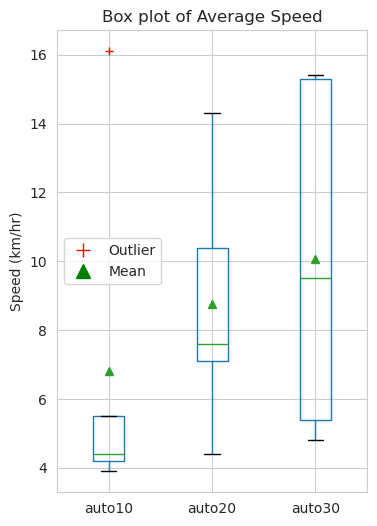

In [22]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
speed_df.boxplot(sym='r+', showmeans=True, )
plt.title('Box plot of Average Speed')
plt.ylabel('Speed (km/hr)')

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.xticks()  # Rotate x-axis labels for better visibility if needed
plt.show()

## Alls users in each subplot

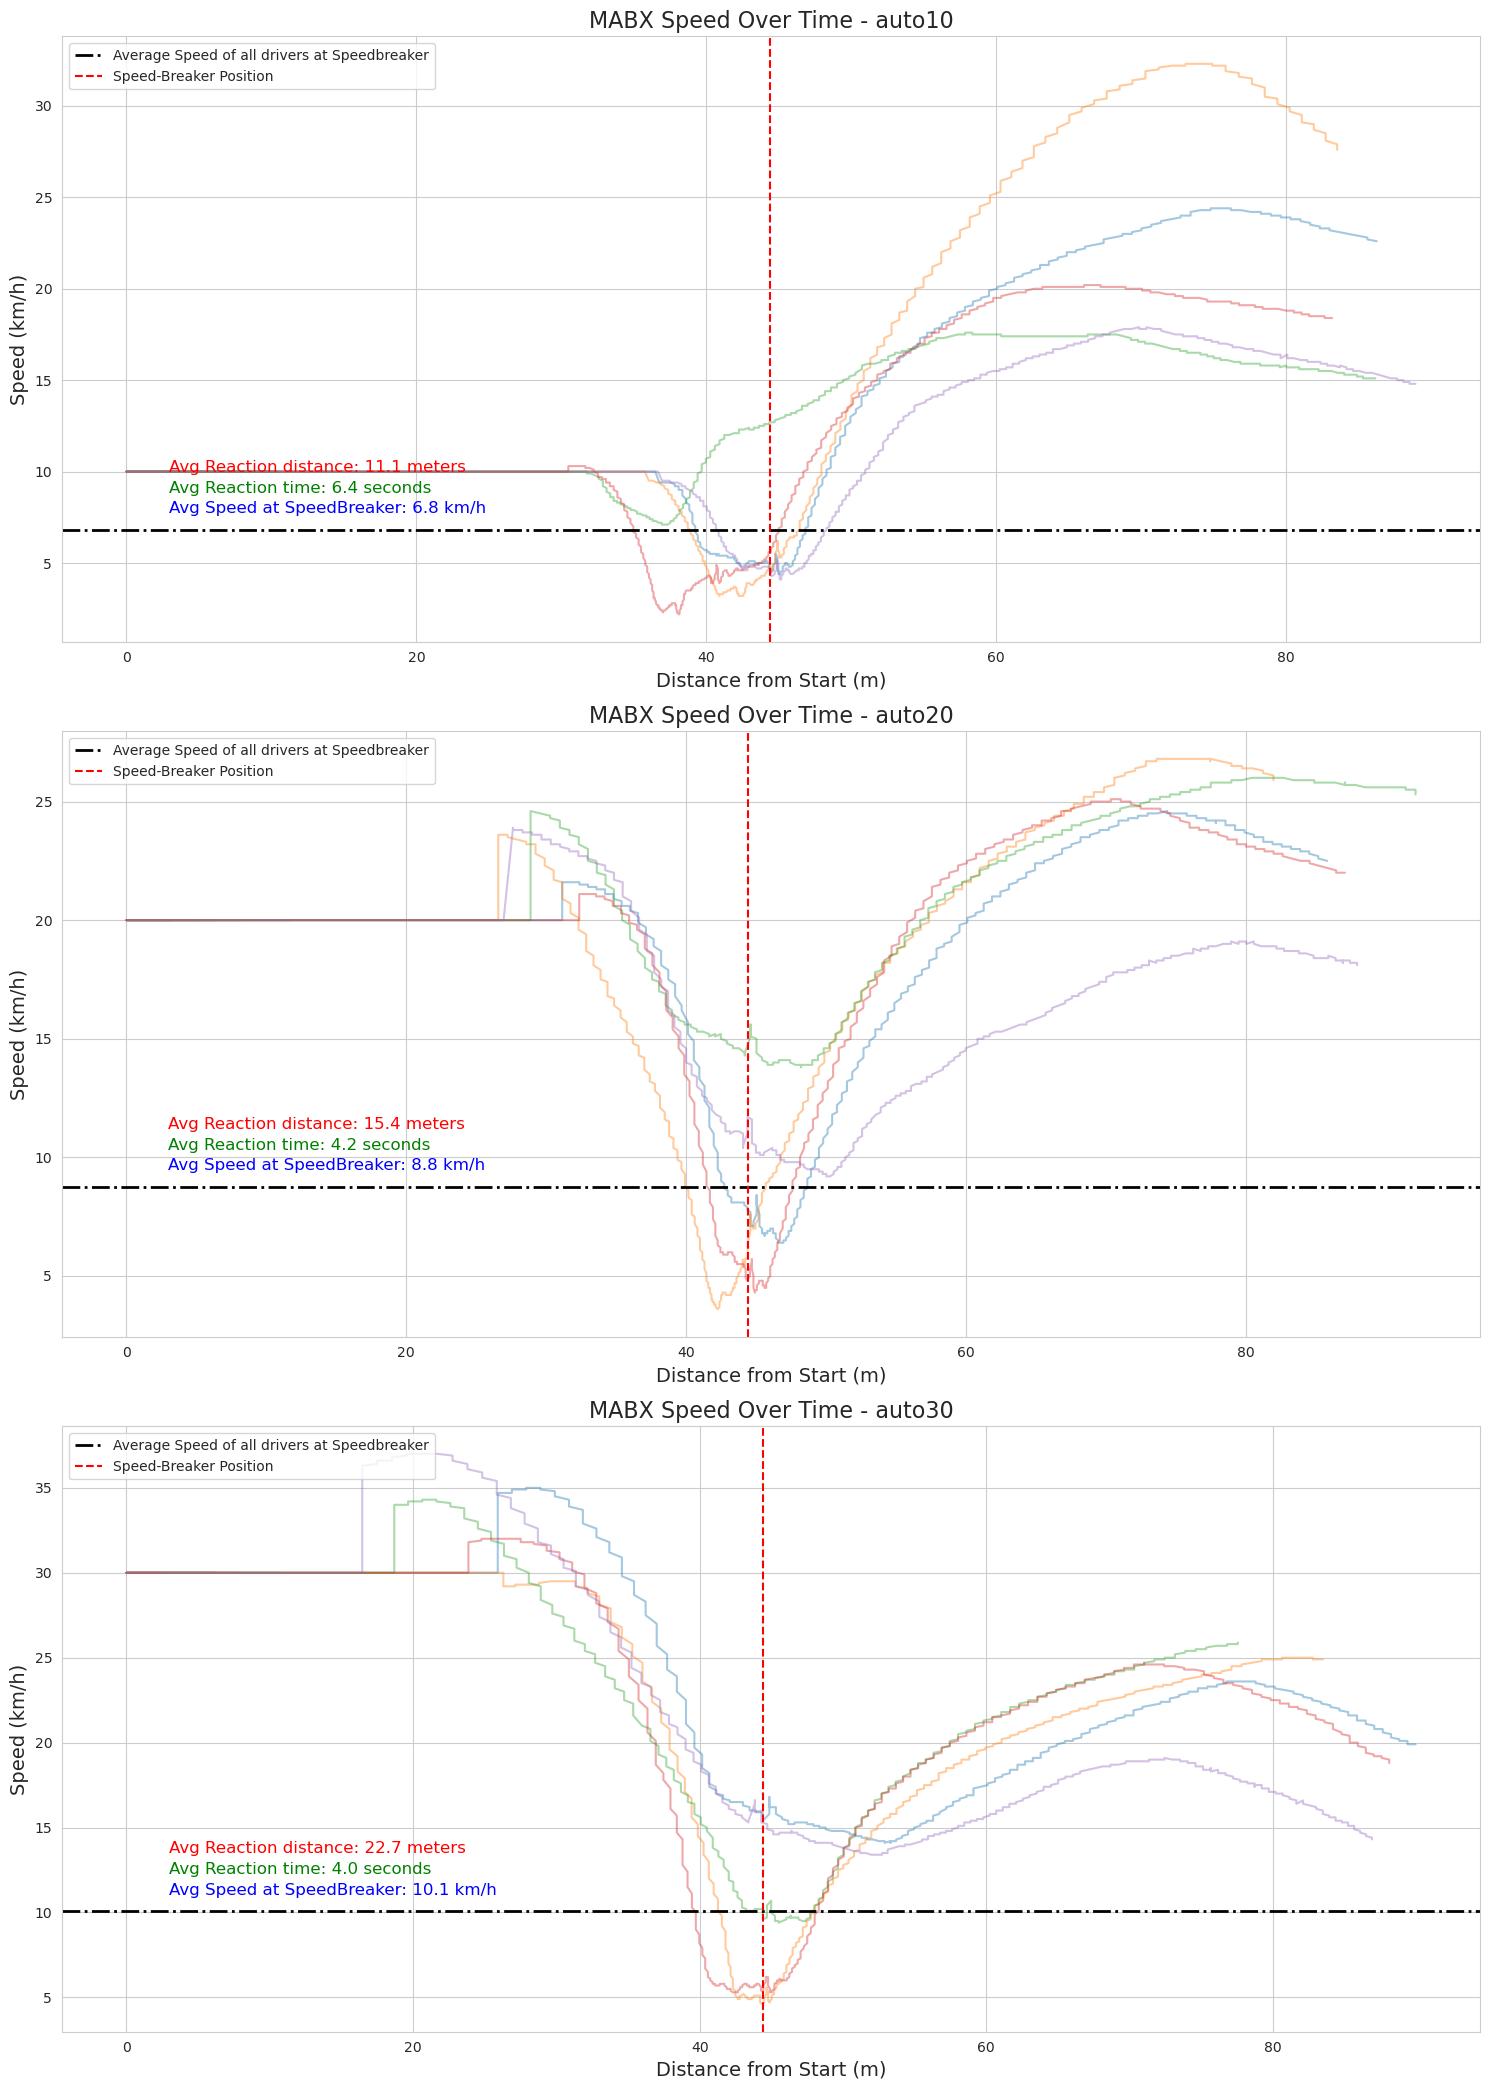

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 7 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 44.4                      # Distance from start to the speed-breaker

        # Add speed at x_value to the list
        x_value_speed = user_df.loc[user_df['nearest_dist_from_start'] == x_value, 'Veh_MABX_Speed'].values
        if x_value_speed.size > 0:
            speedbreaker_speeds.append(x_value_speed[0])

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['nearest_dist_from_start'], user_df['Veh_MABX_Speed'], color=cmap(j % 10), alpha=0.4)
        # axs[i].plot(user_df['nearest_dist_from_start'], user_df['Veh_MABX_Speed'], label=f'Driver {user_name}', color=cmap(j % 10), alpha=0.4)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed of all drivers at Speedbreaker', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed of all drivers at Speedbreaker', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed of all drivers at Speedbreaker', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (2, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (2, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (2, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].xlim = (0, 100)
    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='upper left', fontsize=10)
    
    # Move the legend outside of the plot area
    # axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.show()


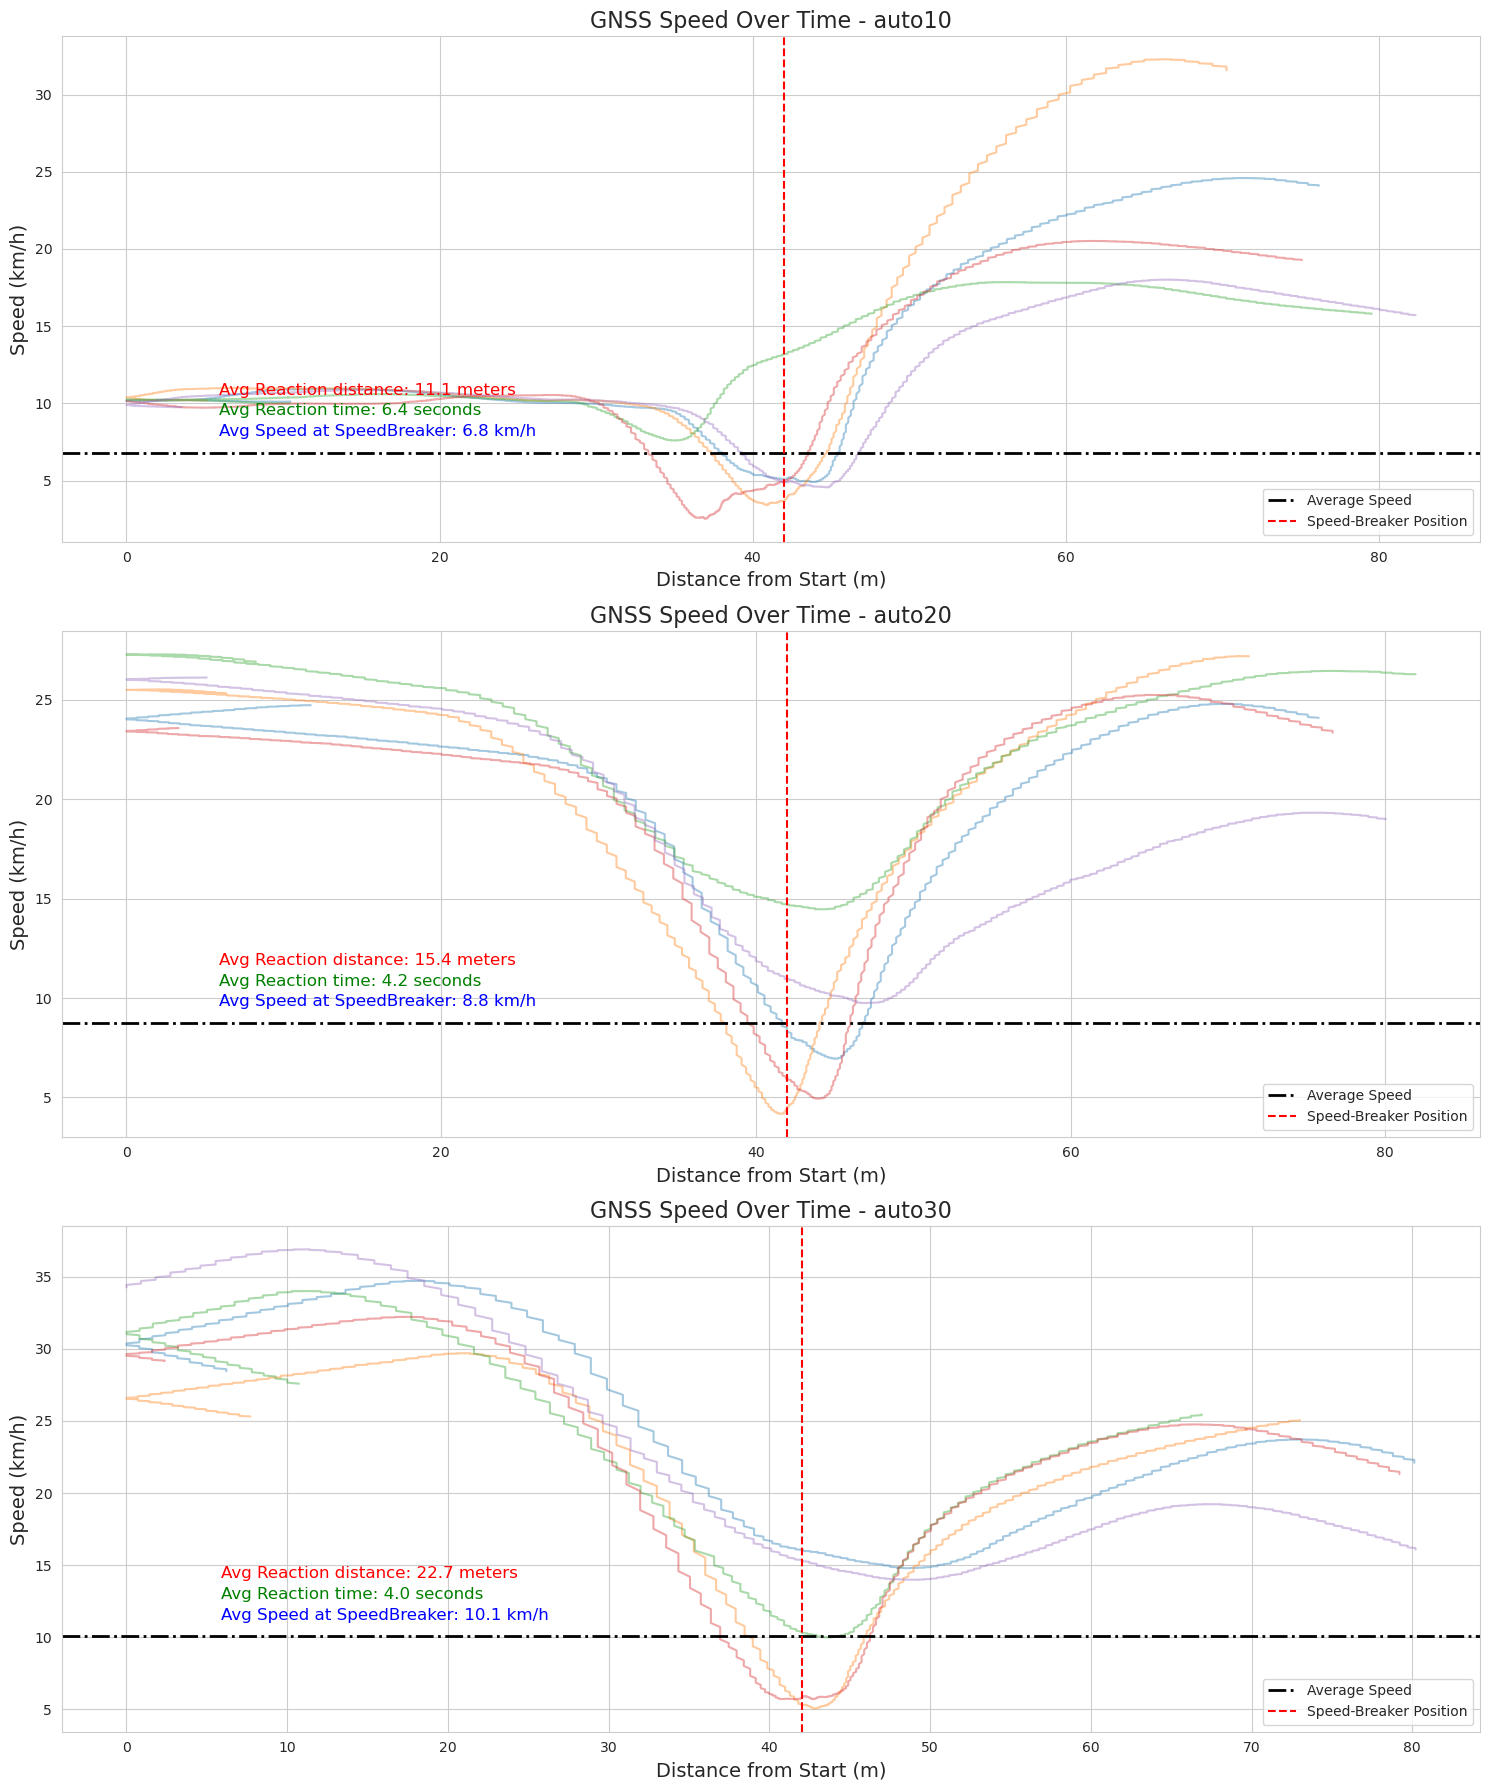

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

# Define a moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 50  # or any other size depending on your data

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    
    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 42
        # Apply moving average to the speed data
        smoothed_speed = moving_average(user_df['Veh_GNSS_Speed'].values, window_size)

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['nearest_dist_from_start'][:-window_size+1], smoothed_speed, color=cmap(j % 10), alpha=0.4)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'GNSS Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


### Multiple Plots for each users

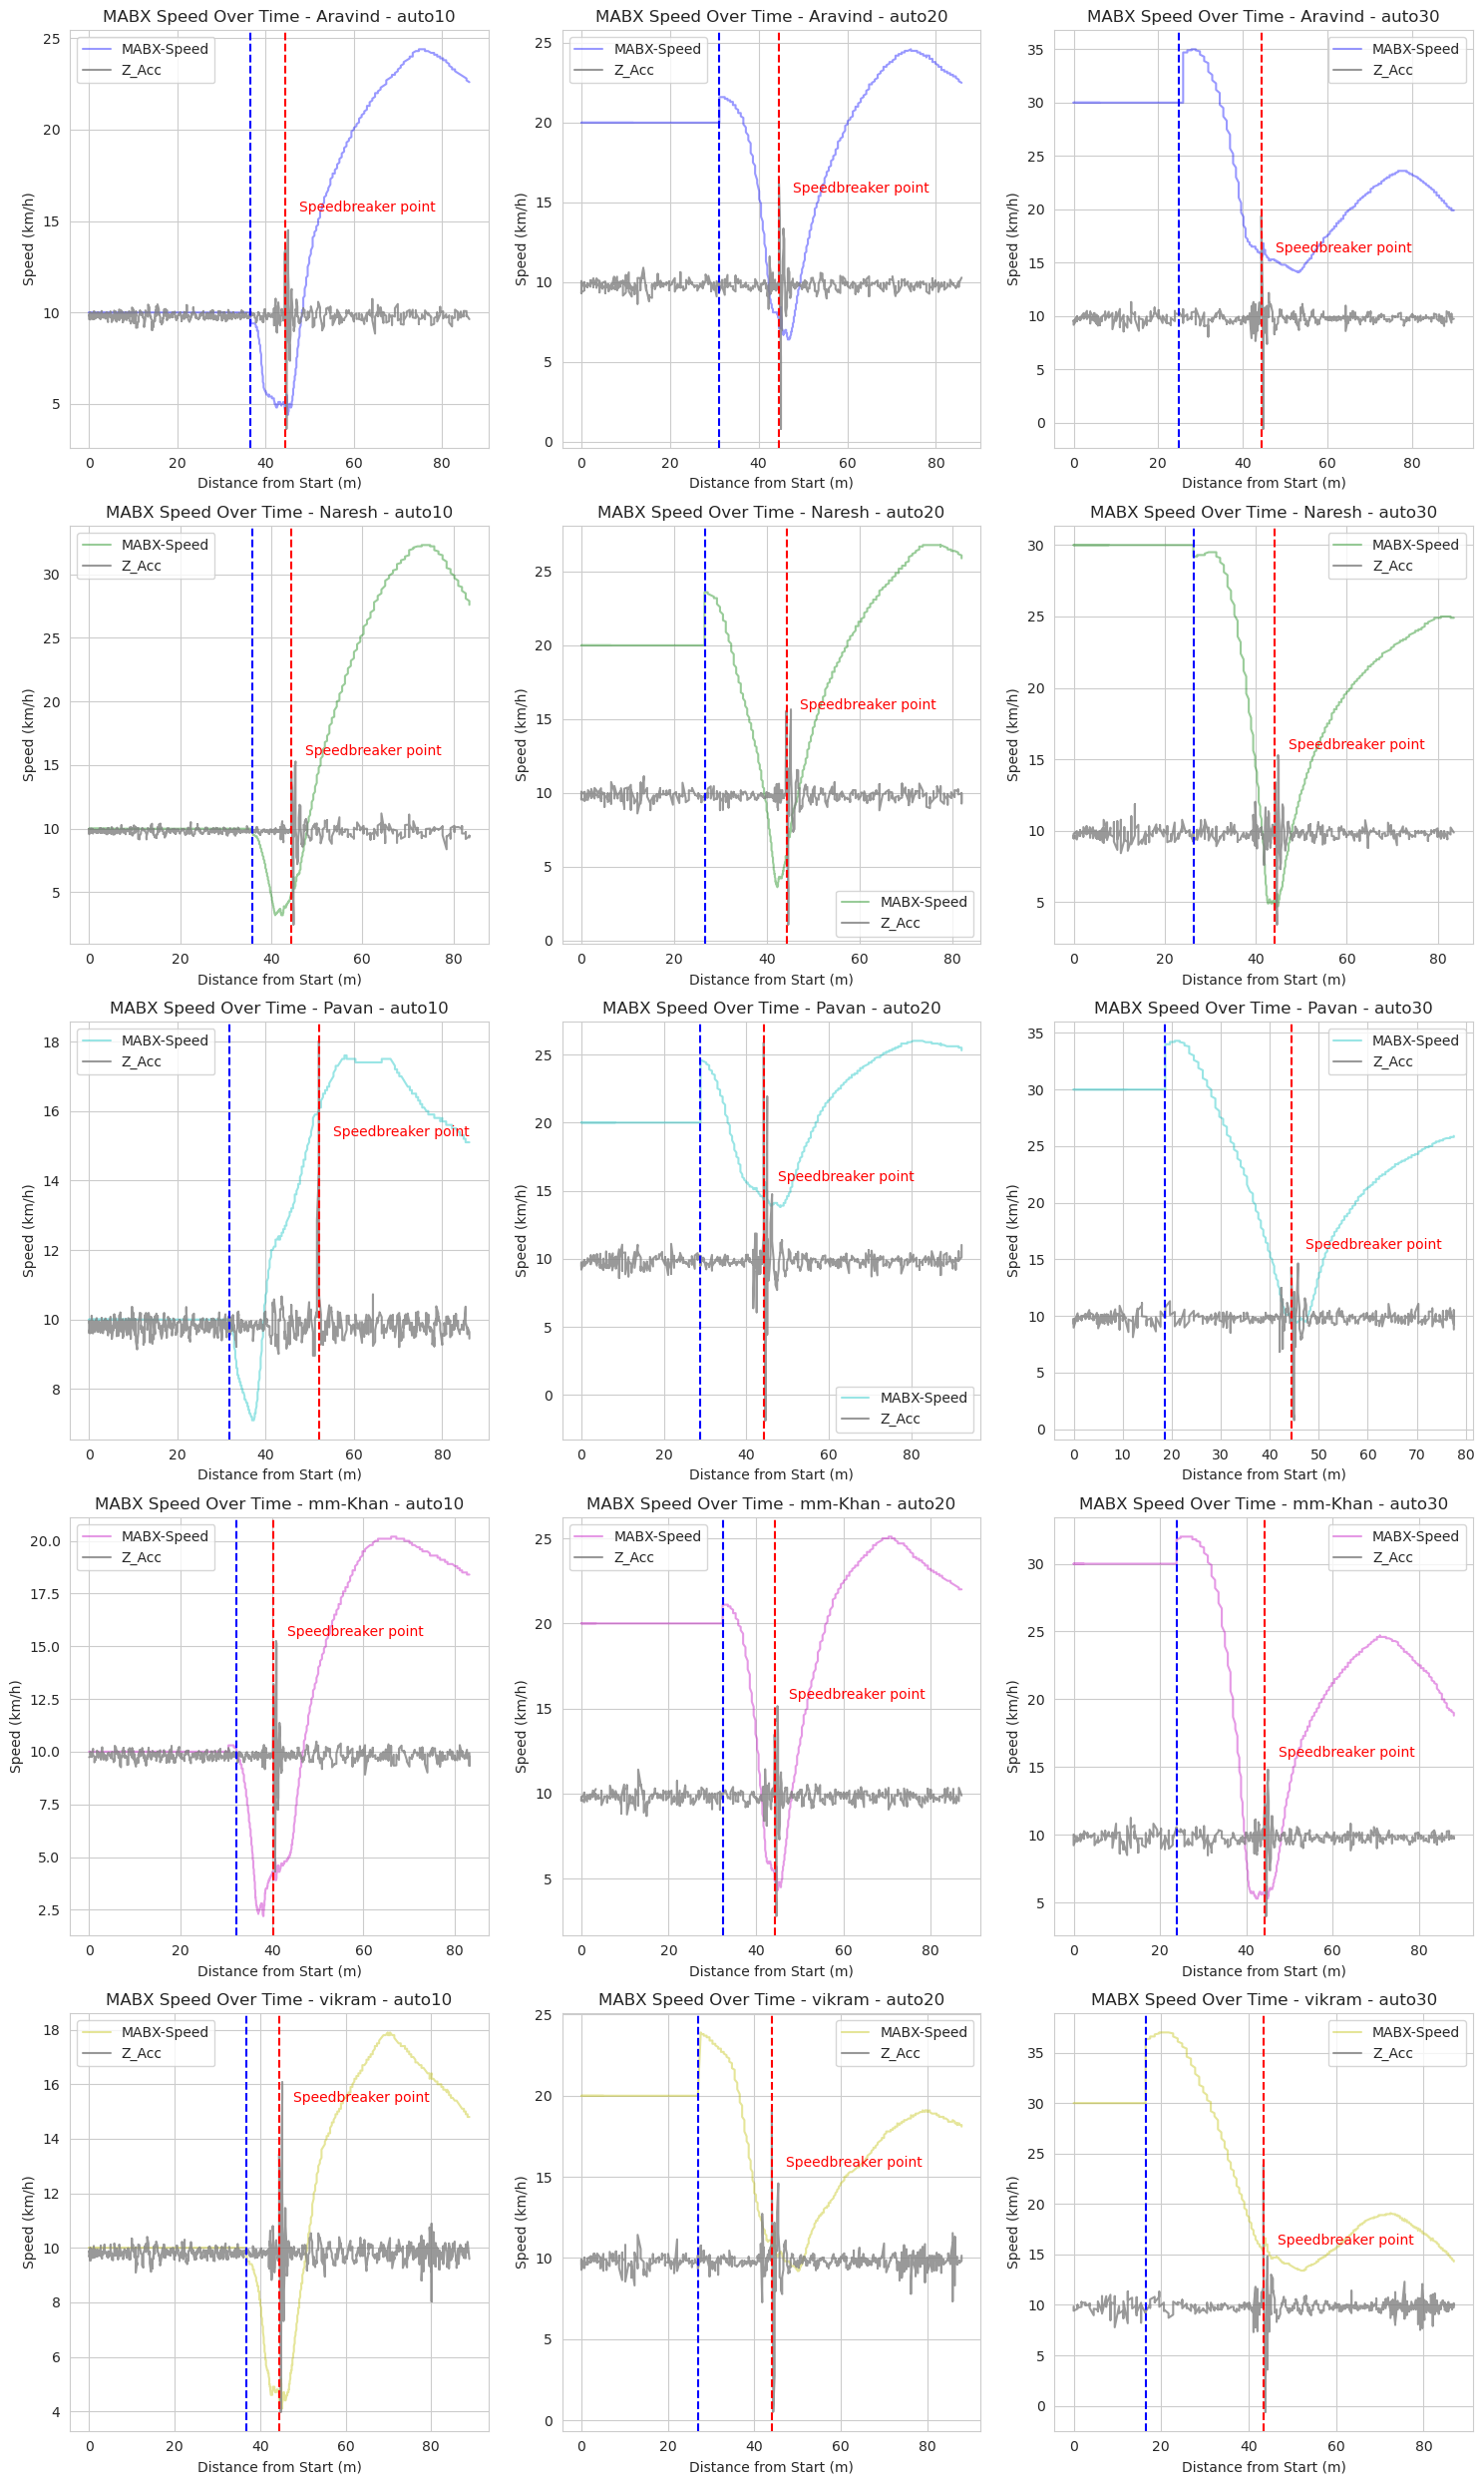

In [25]:
import matplotlib.pyplot as plt

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Flatten the 2D array of subplots into a 1D array
fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))
axs_flat = axs.flatten()

# Define a list of colors
colors = ['b', 'g', 'c', 'm', 'y', 'k']
greycolor = 'grey'

for j, (user_name, user_data) in enumerate(data.items()):
    for i, (df_name, df) in enumerate(user_data.items()):
        start_point = df.loc[starting_point[user_name][df_name]]['nearest_dist_from_start']
        # print(start_point)

        # Extract x value from current dataframe based on the specified condition
        speedbreaker_pos = df.loc[(df['Z_Acc'] > 12), ['nearest_dist_from_start']]['nearest_dist_from_start'].values[1]

        axs_flat[j * num_datasets + i].plot(df['nearest_dist_from_start'], df['Veh_MABX_Speed'], label=f'MABX-Speed', color=colors[j % len(colors)], alpha=0.4)
        axs_flat[j * num_datasets + i].plot(df['nearest_dist_from_start'], df['Z_Acc'], label=f'Z_Acc', color=greycolor, alpha=0.8)

        axs_flat[j * num_datasets + i].set_xlabel('Distance from Start (m)')
        axs_flat[j * num_datasets + i].set_ylabel('Speed (km/h)')
        axs_flat[j * num_datasets + i].set_title(f'MABX Speed Over Time - {user_name} - {df_name}')
        axs_flat[j * num_datasets + i].legend()
        # Draw a vertical line at start_point
        axs_flat[j * num_datasets + i].axvline(x=start_point, color='b', linestyle='--')
        # Draw a vertical line at speedbreaker_pos
        axs_flat[j * num_datasets + i].axvline(x=speedbreaker_pos, color='r', linestyle='--')
        # Speedbreaker text at the speedbreaker_pos
        axs_flat[j * num_datasets + i].annotate('Speedbreaker point', (speedbreaker_pos, 15), xytext=(10, 10), textcoords='offset points', va='center', ha='left', fontsize=10, color='red')

plt.tight_layout()
plt.show()


#### Single Driver

In [26]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# for i, (df_name, df) in enumerate(data['Anish'].items()):

#     # Extract x value from current dataframe based on the specified condition
#     x_value = 44

#     # x_value_end = df.loc[(df['Z_Acc'] < 6) | (df['Z_Acc'] > 15), ['dist_from_start']]['dist_from_start'].values[-1]

#     axs[i].plot(df['nearest_dist_from_start'], df['Veh_MABX_Speed'], label=f'MABX-Speed')
#     # axs[i].plot(df['nearest_dist_from_start'], df['Veh_GNSS_Speed'], label=f'GNSS-Speed')
#     axs[i].plot(df['nearest_dist_from_start'], df['Z_Acc'], label=f'Z-Acc')
#     # axs[i].plot(df['Roll'], label=f'Pitch')

#     axs[i].set_xlabel('Timestamp')
#     axs[i].set_ylabel('Speed (km/h)')
#     axs[i].set_title(f'MABX Speed Over Time - {df_name}')
#     axs[i].legend()

#     # Draw a vertical line at x_value
#     axs[i].axvline(x=x_value, color='r', linestyle='--')
#     # axs[i].axvline(x=x_value_end, color='r', linestyle='--')

# plt.tight_layout()
# plt.show()
